# DMC 2022
### Predicting user-based replenishment of a product based on historical orders and item features 

## 1. Task

The participating teams’ goal is to predict the user-based replenishment of a product based on
historical orders and item features. Individual items and user specific orders are given for the period
between 01.06.2020 and 31.01.2021. The prediction period is between 01.02.2021 and 28.02.2021,
which is exactly four weeks long.
For a predefined subset of user and product combinations, the participants shall predict if and when
a product will be purchased during the prediction period.
The prediction column in the “submission.csv” file must be filled accordingly.
* 0 - no replenishment during that period
* 1 - replenishment in the first week
* 2 - replenishment in the second week
* 3 - replenishment in the third week
* 4 - replenishment in the fourth week

## 2. Problem Definition

The problem we will be exploring is **multiclass classification**. Based on a number of different features we are trying to predict whether a product will be replenished by a certain customer in a specific week 1-4 or not at all 0.

## 3. Tools we are going to use

* [pandas](https://pandas.pydata.org/) for data analysis and data manipulation
* [Knime](https://www.knime.com/) for data analysis (outside of this notebook)
* [NumPy](https://numpy.org/) for numerical operations
* [Matplotlib](https://matplotlib.org/) for visualization
* [Scikit-Learn](https://scikit-learn.org/stable/) for machine learning modeling and evaluation
* [XGBoost](https://xgboost.readthedocs.io/en/stable/) for gradient boosting
* [Hyperopt](http://hyperopt.github.io/hyperopt/) for hyper-parameter optimization

## 4. Features

1. date
2. userID
3. itemID
4. order
5. brand
6. feature_1
7. feature_2
8. feature_3
9. feature_4
10. feature_5
11. categories
12. week

#### Not used
13. RCP
14. parent_category

## Imports and Functions

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sc
import gc

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier

import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

## Read data

In [2]:
#file1 = r'E:\OneDrive\Arbeit\Repos\DMC2022\Kevin\csv\06_complete_dataset_labeled_week0.csv'

file1 = r'E:\OneDrive\Arbeit\Repos\DMC2022\Kevin\csv\04_complete_dataset_labeled_wLastPurchaseDates_noOnetimers.csv'
df_data = pd.read_csv(file1, sep='|', dtype={'userID':np.uint32,
                                            'date':str, 
                                            'itemID':np.uint32,
                                            'order':np.uint8,
                                            'brand':np.uint16,
                                            'feature_1':np.uint8,
                                            'feature_2':np.uint8,
                                            'feature_3':np.uint16,
                                            'feature_4':np.uint8,
                                            'feature_5':np.uint16,
                                            'week':np.uint8})
                     #chunksize=10000)

show_mem_usage(df_data)
df_data.head(10)

Memory usage of dataframe is 14.03 MB


,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week,purchaseDates,lastPurchaseDate
0,2020-06-01,29737,5237,1,1201,10,0,53,3,87,"[327, 3129, 414, 4206]",1,"['2020-06-01', '2020-10-04']",2222-03-03
1,2020-06-01,29737,11535,3,328,4,0,498,3,13,"[715, 3267]",1,"['2020-06-01', '2020-06-07']",2222-03-03
2,2020-06-01,13081,16536,1,615,10,0,6,0,84,"[390, 2080, 536, 1708]",1,"['2020-06-01', '2020-09-04']",2222-03-03
3,2020-06-01,19712,15299,2,1023,10,0,503,0,17,"[3672, 1091, 1085, 1578, 2325]",1,"['2020-06-01', '2020-09-17']",2222-03-03
4,2020-06-01,19712,26623,3,38,10,0,528,0,132,"[2019, 1633, 482]",1,"['2020-06-01', '2020-09-17']",2222-03-03
5,2020-06-01,34083,18169,1,73,10,0,421,3,3,"[2116, 3224, 3156, 2690]",1,"['2020-06-01', '2020-09-12']",2222-03-03
6,2020-06-01,23038,31567,1,408,4,0,334,0,44,"[1711, 2621, 2919]",1,"['2020-06-01', '2020-09-16']",2222-03-03
7,2020-06-01,40277,30133,1,408,4,0,334,0,44,"[1711, 2621, 2919, 3924, 3915, 3914]",1,"['2020-06-01', '2020-07-29']",2222-03-03
8,2020-06-01,29971,8793,1,990,4,0,474,0,65535,"[3867, 1998, 3025, 46, 3649, 3915, 3914]",1,"['2020-06-01', '2020-08-10']",2222-03-03
9,2020-06-01,22109,8004,1,6,6,0,303,3,45,"[2977, 1772, 1118, 4025, 4026]",1,"['2020-06-01', '2020-08-21']",2222-03-03


In [3]:
df_data.drop('lastPurchaseDate', axis=1, inplace=True)
df_data.drop('purchaseDates', axis=1, inplace=True)
df_data.head(10)

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,29737,5237,1,1201,10,0,53,3,87,"[327, 3129, 414, 4206]",1
1,2020-06-01,29737,11535,3,328,4,0,498,3,13,"[715, 3267]",1
2,2020-06-01,13081,16536,1,615,10,0,6,0,84,"[390, 2080, 536, 1708]",1
3,2020-06-01,19712,15299,2,1023,10,0,503,0,17,"[3672, 1091, 1085, 1578, 2325]",1
4,2020-06-01,19712,26623,3,38,10,0,528,0,132,"[2019, 1633, 482]",1
5,2020-06-01,34083,18169,1,73,10,0,421,3,3,"[2116, 3224, 3156, 2690]",1
6,2020-06-01,23038,31567,1,408,4,0,334,0,44,"[1711, 2621, 2919]",1
7,2020-06-01,40277,30133,1,408,4,0,334,0,44,"[1711, 2621, 2919, 3924, 3915, 3914]",1
8,2020-06-01,29971,8793,1,990,4,0,474,0,65535,"[3867, 1998, 3025, 46, 3649, 3915, 3914]",1
9,2020-06-01,22109,8004,1,6,6,0,303,3,45,"[2977, 1772, 1118, 4025, 4026]",1


# Preprocessing

In [4]:
df_data = df_data.sort_values('date')
df_data.head(10)

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,29737,5237,1,1201,10,0,53,3,87,"[327, 3129, 414, 4206]",1
972,2020-06-01,1564,13700,2,361,6,0,200,3,17,"[2995, 3654, 997, 3970, 3934]",1
971,2020-06-01,1564,28815,1,449,6,0,218,3,45,"[3459, 3969]",1
970,2020-06-01,1564,14214,1,322,4,0,536,0,144,"[3078, 2322, 160]",1
969,2020-06-01,1564,14121,2,941,6,0,170,0,45,"[1772, 1505, 1350, 4049]",1
968,2020-06-01,15744,32585,1,314,4,0,514,0,187,"[1098, 2866]",1
967,2020-06-01,15744,219,1,393,4,0,491,3,66,"[3775, 1524, 1807, 2470, 503, 211, 5, 2048, 39...",1
966,2020-06-01,15744,27932,1,748,10,0,492,0,121,"[2002, 2273, 1524, 1807]",1
965,2020-06-01,34705,21280,1,410,10,0,421,0,3,"[3224, 2690, 1465]",1
973,2020-06-01,4864,21146,1,325,4,0,267,0,78,"[3259, 237, 987, 3344, 2598, 978, 3915, 3914]",1


### Multi-Hot-Encoding for categories

In contrast to One-Hot-Encoding where a column contains a single value which is converted to a one in the respective column, Multi-Hot-Encoding converts multiple entries in one cell to multiple ones in different columns. Therefore we first have to process the string in our category column, such that we can convert it into columns, without having duplicates.

#### Memory problem after Multi-Hot-Encoding
The problem we face when Multi-Hot-Encoding our categories is the following: After preprocessing and encoding we have 3.040.458.033 data points (904091 rows × 3363 columns). When trying to encode our categories with the str.get_dummies() method the size of the resulting dataframe is about ~30 GB depending on how many rows and features we are using. With a dataframe this big we run into memory problems when processing our data and building our model. 

#### Solution
There are are couple of different solutions to work around this problem. Normally we could work around memory limiations using batch processing or external memory. In case of the DMC dataset this is not optimal, since we need the whole customer history to make accurate predictions.

Since most of the colums we create from Multi-Hot-Encoding will be filled with zeros, we will be using a sparse matrix to significantly reduce the size of the resulting dataframe. The reduction we achieve with this approach results in dataframe size of 113 MB instead of ~30 GB.

In [5]:
# Convert strings to lists of integers in 'categories'
df_cat = df_data

df_cat["categories"] = df_cat["categories"].apply(lambda x: [int(i) for i in x[1:-1].split(',')])
df_cat["categories"]

0                                    [327, 3129, 414, 4206]
972                           [2995, 3654, 997, 3970, 3934]
971                                            [3459, 3969]
970                                       [3078, 2322, 160]
969                                [1772, 1505, 1350, 4049]
                                ...                        
287136                                   [2300, 3914, 4123]
287135    [2178, 646, 644, 1463, 1390, 3915, 4019, 2096,...
287134                                               [1350]
287102    [545, 2950, 278, 3915, 3912, 1808, 1032, 3914,...
288432                                       [47, 530, 279]
Name: categories, Length: 288433, dtype: object

In [6]:
# Multi-Hot-Encode columns with sparse output
c = df_cat["categories"]
mlb = MultiLabelBinarizer(sparse_output=False) # Set to True if output binary array is desired in CSR sparse format
df_multi_hot = pd.DataFrame(mlb.fit_transform(c), columns=mlb.classes_, index=None, dtype=np.int8)

show_mem_usage(df_multi_hot)

Memory usage of dataframe is 816.41 MB


In [7]:
# Convert dataframe to sparse type
sparse_df_mh = df_multi_hot.astype(pd.SparseDtype("float64",0))
print(sparse_df_mh.info())
sparse_df_mh

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288433 entries, 0 to 288432
Columns: 2968 entries, 0 to 4299
dtypes: Sparse[float64, 0](2968)
memory usage: 21.9 MB
None


,0,1,2,4,5,6,7,12,13,14,...,4281,4282,4284,4285,4286,4287,4288,4289,4290,4299
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
del df_multi_hot
gc.collect()

0

In [9]:
%%time

# Combine df_data and sparse_df_mh
df_combined = df_cat.join(sparse_df_mh, how='inner')
show_mem_usage(df_combined)
df_combined.head()

Memory usage of dataframe is 33.77 MB
CPU times: total: 27.7 s
Wall time: 27.7 s


,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4281,4282,4284,4285,4286,4287,4288,4289,4290,4299
0,2020-06-01,29737,5237,1,1201,10,0,53,3,87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
972,2020-06-01,1564,13700,2,361,6,0,200,3,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
971,2020-06-01,1564,28815,1,449,6,0,218,3,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,2020-06-01,1564,14214,1,322,4,0,536,0,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
969,2020-06-01,1564,14121,2,941,6,0,170,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# pop and append 'week' at end of dataframe
col = df_combined.pop("week")
df_combined.insert(len(df_combined.columns), col.name, col)
df_combined.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4282,4284,4285,4286,4287,4288,4289,4290,4299,week
0,2020-06-01,29737,5237,1,1201,10,0,53,3,87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
972,2020-06-01,1564,13700,2,361,6,0,200,3,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
971,2020-06-01,1564,28815,1,449,6,0,218,3,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
970,2020-06-01,1564,14214,1,322,4,0,536,0,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
969,2020-06-01,1564,14121,2,941,6,0,170,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
# Check if we have any missing values
df_combined[df_combined.isnull().any(axis=1)]

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4282,4284,4285,4286,4287,4288,4289,4290,4299,week


In [12]:
df_combined.drop('categories', axis=1, inplace=True)
show_mem_usage(df_combined)

Memory usage of dataframe is 31.57 MB


# Model

### Splitting Training- / Testdata

In [13]:
df = df_combined.copy()
id(df), id(df_combined)

(2306484034864, 2306402227632)

In [14]:
df.sort_values('date')

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4282,4284,4285,4286,4287,4288,4289,4290,4299,week
0,2020-06-01,29737,5237,1,1201,10,0,53,3,87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2020-06-01,29737,11535,3,328,4,0,498,3,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2020-06-01,13081,16536,1,615,10,0,6,0,84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2020-06-01,19712,15299,2,1023,10,0,503,0,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2020-06-01,19712,26623,3,38,10,0,528,0,132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288429,2021-01-31,37780,8929,10,193,4,3,245,3,108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
288430,2021-01-31,6499,1109,3,1156,6,0,124,3,117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
287466,2021-01-31,23073,2811,2,1368,6,0,484,0,117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
288312,2021-01-31,25059,30671,3,703,4,0,335,3,70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [15]:
df.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4282,4284,4285,4286,4287,4288,4289,4290,4299,week
0,2020-06-01,29737,5237,1,1201,10,0,53,3,87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
972,2020-06-01,1564,13700,2,361,6,0,200,3,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
971,2020-06-01,1564,28815,1,449,6,0,218,3,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
970,2020-06-01,1564,14214,1,322,4,0,536,0,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
969,2020-06-01,1564,14121,2,941,6,0,170,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [16]:
# Get index of first occurance of january date for split
idx = df.date.searchsorted('2021-01-01', side='left') # list needs to be sorted already for searchsorted
idx

244765

In [17]:
# check index
df['date'][idx], df['date'][idx - 1]

('2021-01-01', '2020-12-31')

In [18]:
# drop date
df.drop('date', axis=1, inplace=True)

In [19]:
# Comma is being used to extract a specific column from a 2D array.
# X = data.iloc[:,:-1]
# X = all rows, all columns except the last one 

X = df.iloc[:,0:-1]
X

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4281,4282,4284,4285,4286,4287,4288,4289,4290,4299
0,29737,5237,1,1201,10,0,53,3,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
972,1564,13700,2,361,6,0,200,3,17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
971,1564,28815,1,449,6,0,218,3,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,1564,14214,1,322,4,0,536,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
969,1564,14121,2,941,6,0,170,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287136,45760,32646,1,632,4,0,536,3,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287135,33330,18498,1,1401,4,0,95,0,44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287134,33330,15020,1,1180,4,0,172,0,44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287102,42496,12528,3,186,4,3,17,0,81,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
y = df.iloc[:,-1]
y

0         1
972       1
971       1
970       1
969       1
         ..
287136    4
287135    4
287134    4
287102    4
288432    4
Name: week, Length: 288433, dtype: uint8

In [21]:
# Split training/test data
# train = jun-dec20 / test = jan21

X_train = X.iloc[:idx-1]
X_test = X.iloc[idx:]
y_train = y.iloc[:idx-1]
y_test = y.iloc[idx:]

In [22]:
#X_test.sample(frac=1)

In [23]:
show_mem_usage(X_train), show_mem_usage(X_test)
X_train

Memory usage of dataframe is 24.78 MB
Memory usage of dataframe is 4.31 MB


,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4281,4282,4284,4285,4286,4287,4288,4289,4290,4299
0,29737,5237,1,1201,10,0,53,3,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
972,1564,13700,2,361,6,0,200,3,17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
971,1564,28815,1,449,6,0,218,3,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,1564,14214,1,322,4,0,536,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
969,1564,14121,2,941,6,0,170,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244400,18754,11188,3,6,4,0,71,0,53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244402,18322,12271,1,617,10,0,536,3,156,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244403,18322,24815,1,1105,6,0,486,3,117,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244404,15539,23669,3,703,4,0,291,0,44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y_train

0         1
972       1
971       1
970       1
969       1
         ..
244400    4
244402    4
244403    4
244404    4
244405    4
Name: week, Length: 244764, dtype: uint8

In [25]:
# Split training and test data
# parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

#show_mem_usage(X_train), show_mem_usage(X_test)

# DecisionTreeClassifier

In [26]:
X_train

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4281,4282,4284,4285,4286,4287,4288,4289,4290,4299
0,29737,5237,1,1201,10,0,53,3,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
972,1564,13700,2,361,6,0,200,3,17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
971,1564,28815,1,449,6,0,218,3,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,1564,14214,1,322,4,0,536,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
969,1564,14121,2,941,6,0,170,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244400,18754,11188,3,6,4,0,71,0,53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244402,18322,12271,1,617,10,0,536,3,156,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244403,18322,24815,1,1105,6,0,486,3,117,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244404,15539,23669,3,703,4,0,291,0,44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
y_test

245261    1
245265    1
245260    1
245262    1
245259    1
         ..
287136    4
287135    4
287134    4
287102    4
288432    4
Name: week, Length: 43668, dtype: uint8

In [35]:
%%time

classifier = DecisionTreeClassifier()
classifier = classifier.fit(X_train,y_train)

CPU times: total: 5min 25s
Wall time: 5min 25s


In [37]:
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

dct_train = accuracy_score(y_train, y_train_pred)
dct_test = accuracy_score(y_test, y_test_pred)
print()
print(f'Decision Tree train/test accuracies: '
     f'{dct_train:.3f}/{dct_test:.3f}')


Decision Tree train/test accuracies: 0.999/0.265


In [30]:
#y_test_pred = list(y_test_pred)
#y_test2 = list(y_test)

In [31]:
#for i in range(len(y_test)):
#    print(y_test2[i],y_test_pred[i])

In [32]:
%%time

# Model with standard settings
model1 = XGBClassifier()
gbm = model1.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

xgb_train = accuracy_score(y_train, y_train_pred)
xgb_test = accuracy_score(y_test, y_test_pred)
print()
print(f'XGboost train/test accuracies: '
     f'{xgb_train:.3f}/{xgb_test:.3f}')

[08:21:24] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGboost train/test accuracies: 0.343/0.336
CPU times: total: 2h 41min 57s
Wall time: 7min 23s


<AxesSubplot:>

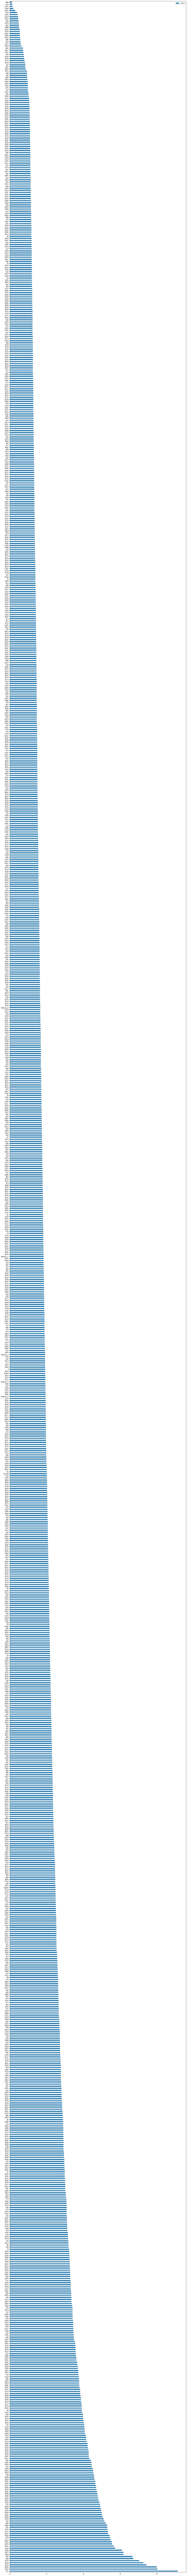

In [36]:
# ‘gain’: the average gain across all splits the feature is used in.
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
feature_important = gbm.get_booster().get_score(importance_type='gain') # 'gbm' -> Model
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(2977, columns="score").plot(kind='barh', figsize = (20,300)) ## plot top 40 features

### Define domain space for range of values 

In [38]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

### Define objective function

In [39]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

### Minimize the objective over the space

In [40]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

SCORE:                                                
0.2230466245305487                                    
SCORE:                                                                           
0.2230466245305487                                                               
SCORE:                                                                           
0.2230466245305487                                                               
SCORE:                                                                           
0.2230466245305487                                                               
SCORE:                                                                           
0.2230466245305487                                                               
SCORE:                                                                           
0.2230466245305487                                                               
SCORE:                                                                

0.2230466245305487                                                                
100%|██████████| 50/50 [10:37<00:00, 12.76s/trial, best loss: -0.2230466245305487]


In [43]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5811873959600025, 'gamma': 2.960865883275109, 'max_depth': 13.0, 'min_child_weight': 5.0, 'reg_alpha': 110.0, 'reg_lambda': 0.7508849844044778}


In [ ]:
"""space = { 'eta': hp.quniform('eta', 0.025, 0.5, 0.05),
        'max_depth': hp.quniform("max_depth", 1, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }
"""

In [ ]:
"""
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }
"""

In [ ]:
"""
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
"""

In [41]:
!conda list

# packages in environment at C:\Users\kevin\anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py39haa95532_0  
_py-xgboost-mutex         2.0                       cpu_0    conda-forge
aiohttp                   3.8.1            py39h2bbff1b_1  
aiosignal                 1.2.0              pyhd3eb1b0_0  
alabaster                 0.7.12             pyhd3eb1b0_0  
anaconda                  2022.05                  py39_0  
anaconda-client           1.9.0            py39haa95532_0  
anaconda-navigator        2.2.0            py39haa95532_0  
anaconda-project          0.10.2             pyhd3eb1b0_0  
anyio                     3.5.0            py39haa95532_0  
appdirs                   1.4.4              pyhd3eb1b0_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py39h2bbff1b_0  
arrow                     1.2.2              pyhd3eb1b0_0  
astroid                

In [42]:
!pip list

Package                       Version
----------------------------- --------------------
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.9.0
anaconda-navigator            2.2.0
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
bea